# Minimum Spanning Tree Clustering

This is a short notebook describing the Minimum Spanning Tree (MST) Clustering algorithm implemented at [http://github.com/jakevdp/mst_clustering/](http://github.com/jakevdp/mst_clustering/).
The API of the clustering estimator is compatible with scikit-learn.

Note that MST clustering is effectively identical to single-linkage Agglomerative Clustering, but uses a top-down approach rather than a bottom-up approach.
Similar methods are implemented in scikit-learn's [Agglomerative Clustering](http://scikit-learn.org/stable/modules/clustering.html#hierarchical-clustering) estimator.

We'll start with some initial imports and definitions; you can ignore this for now:

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

# matplotlib 1.4 + numpy 1.10 produces warnings; we'll filter these
import warnings; warnings.filterwarnings('ignore', message='elementwise')

def plot_mst(model, cmap='rainbow'):
    """Utility code to visualize a minimum spanning tree"""
    X = model.X_fit_
    fig, ax = plt.subplots(1, 2, figsize=(16, 6), sharex=True, sharey=True)
    for axi, full_graph, colors in zip(ax, [True, False], ['lightblue', model.labels_]):
        segments = model.get_graph_segments(full_graph=full_graph)
        axi.plot(segments[0], segments[1], '-k', zorder=1, lw=1)
        axi.scatter(X[:, 0], X[:, 1], c=colors, cmap=cmap, zorder=2)
        axi.axis('tight')
    
    ax[0].set_title('Full Minimum Spanning Tree', size=16)
    ax[1].set_title('Trimmed Minimum Spanning Tree', size=16);

## Example and Explanation of the Algorithm

Minimum Spanning Tree clustering is a very intuitive algorithm.
Consider the following data:

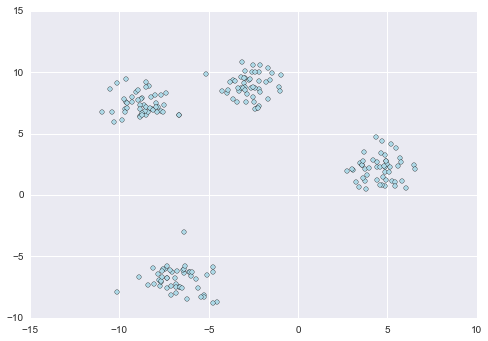

In [2]:
from sklearn.datasets import make_blobs
X, y = make_blobs(200, centers=4, random_state=42)
plt.scatter(X[:, 0], X[:, 1], c='lightblue');

By eye we can see that it contains four well-separated clusters, and a clustering algorithm should be able to find these.
The ``MSTClustering`` estimator can accomplish this quite well:

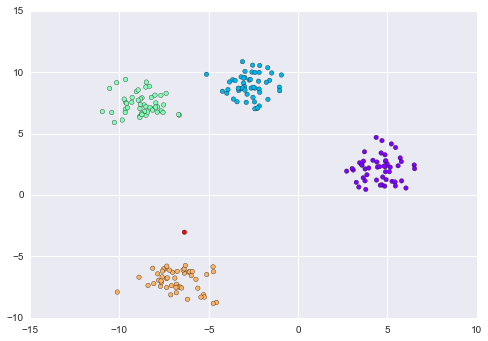

In [3]:
from mst_clustering import MSTClustering
model = MSTClustering(cutoff_scale=2, approximate=False)
labels = model.fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='rainbow');

Notice that the algorithm finds five clusters: the one outlier near the yellow cluster is put in its own group.

This clustering result is computed by first constructing a graph from the input data, with nodes given by points in the dataset and edges given by distances between pairs of points.
Then we find a [Minimum Spanning Tree](https://en.wikipedia.org/wiki/Minimum_spanning_tree) (MST) over this graph: an MST is a subgraph that connects all nodes such that the sum of the graph edges is minimized.

We can see a representation of the minimum spanning tree over this data in the left panel of the following plot:

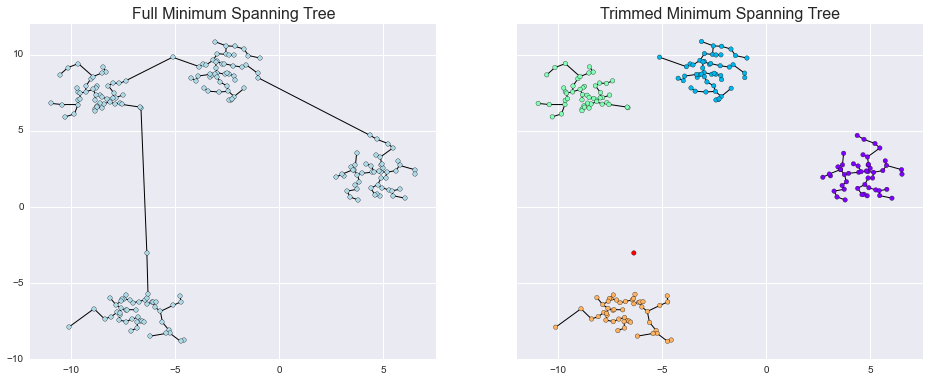

In [4]:
plot_mst(model)

The right panel shows the clusters derived from this minimum spanning tree, by removing all graph edges larger than the specified ``cutoff_scale`` parameter (here, ``cutoff_scale = 2``).
Points which remain connected after the truncation are given the same label.

## Strengths of MST clustering

MST clustering has several advantages over other clustering algorithms:

1. MST clustering is capable of detecting clusters with very irregular boundaries. This compares favorably to K Means, Meanshift, GMM, etc.
2. The number of clusters is not decided *a priori* as in many other algorithms. This compares favorably to K Means, some Spectral methods, etc.
3. A suitably tuned algorithm can detect clusters within background noise. This compares favorably to most other methods.
4. Perhaps most importantly, the tuning parameters of the clustering have very intuitive meanings, and thus MST clustering can be a useful method for scientific data in which the user has a good prior knowledge regarding the meaningful length scale and/or cluster size.

Many of these advantages are shared with, e.g. [DBSCAN](https://en.wikipedia.org/wiki/DBSCAN) which uses a similar but conceptually distinct model.

## Clusters In Background Noise

Let's take a look at the results of MST clustering in the presense of background noise.
Consider this data:

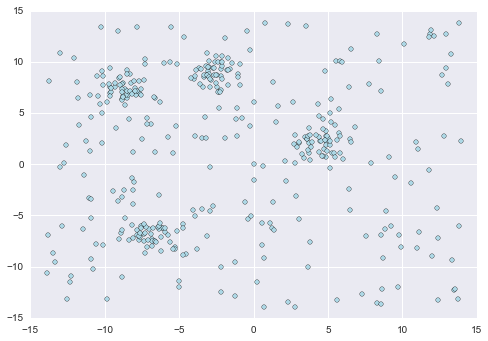

In [5]:
rng = np.random.RandomState(int(100 * y[-1]))
noise = -14 + 28 * rng.rand(200, 2)

X_noisy = np.vstack([X, noise])
y_noisy = np.concatenate([y, np.full(200, -1, dtype=int)])

plt.scatter(X_noisy[:, 0], X_noisy[:, 1], c='lightblue', cmap='spectral_r')
plt.xlim(-15, 15)
plt.ylim(-15, 15);

We can see that there are four distinct overdensities in this data.
Let's take a look at what the minimum spanning tree does in this case:

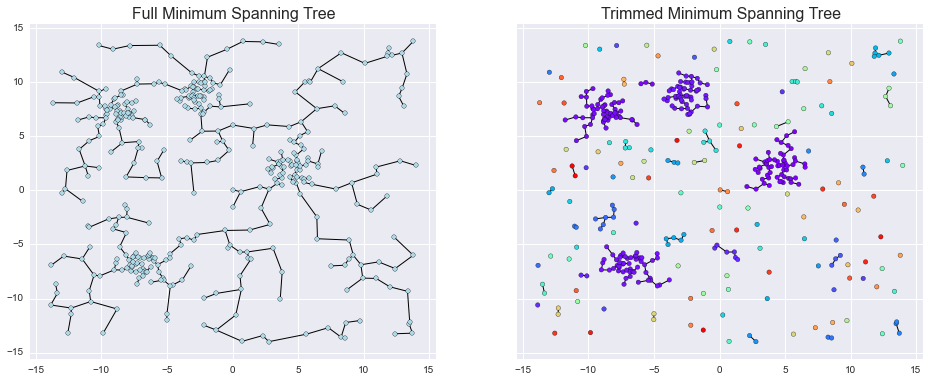

In [6]:
noisy_model = MSTClustering(cutoff_scale=1)
noisy_model.fit(X_noisy)
plot_mst(noisy_model)

Cutting the long edges does separate the four large clusters, but it also leads to a large number of isolated clusters with just a handful of points.
We can easily filter these out by specifying a minimum cluster size; all points which don't belong to a large enough cluster are grouped together with the label ``-1``:

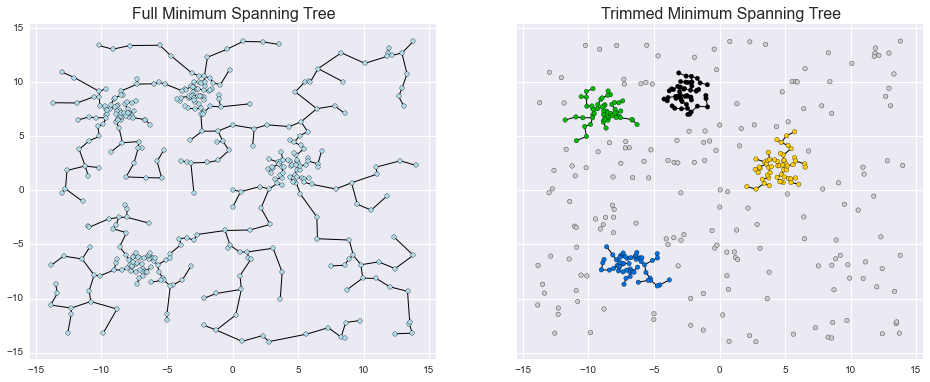

In [7]:
noisy_model = MSTClustering(cutoff_scale=1, min_cluster_size=10)
noisy_model.fit(X_noisy)
plot_mst(noisy_model, cmap='spectral_r')

Thus, by appropriately tuning the cutoff scale and the minimum number of points per cluster, you can recover even clusters within a noisy background.

## Future Work

There are [methods in the literature](http://ieeexplore.ieee.org/xpls/abs_all.jsp?arnumber=4031882&tag=1) that discuss how to tune these parameters automatically; I hope to implement some of them in this package in the future.